### Configuration et Utils

In [2]:

import random, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import gradio as gr
import os

# --- Fonctions Utilitaires ---

def set_seed(seed=42):
    """Initialise les générateurs de nombres aléatoires pour la reproductibilité."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Configuration pour les GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def device():
    """Détermine et retourne l'appareil (GPU ou CPU) disponible pour le calcul."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Hyperparamètres Globaux (issue de run_training.py) ---
cfg = {
    "seed": 42,
    "img_size": 128,
    "batch_size": 8,
    "epochs": 3,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_workers": 0
}

# --- Initialisation ---
set_seed(cfg["seed"])
dev = device()
print(f"Appareil utilisé: {dev}")
print(f"Taille des images: {cfg['img_size']}x{cfg['img_size']}")

Appareil utilisé: cpu
Taille des images: 128x128


### Définition des Modèles

In [3]:

class SmallCNN(nn.Module):
    """Architecture CNN simple et personnalisée."""
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

def build_resnet50(num_classes=2, pretrained=True):
    """Charge ResNet-50 et remplace la couche de classification finale."""
    m = resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    # Remplacement de la couche fully connected
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_efficientnet_b0(num_classes=2, pretrained=True):
    """Charge EfficientNet-B0 et remplace la couche de classification finale."""
    m = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT if pretrained else None)
    # Remplacement de la dernière couche du classifieur
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    return m

def get_model(name="cnn_custom", num_classes=2, pretrained=True):
    """Fonction d'interface pour instancier le modèle spécifié."""
    name = name.lower()
    if name in ["cnn_custom","cnn","custom"]:
        return SmallCNN(num_classes)
    if name in ["resnet50","resnet"]:
        return build_resnet50(num_classes, pretrained)
    if name in ["efficientnet_b0", "efficientnet", "effnet"]:
        return build_efficientnet_b0(num_classes, pretrained)
    raise ValueError(f"Modèle inconnu: {name}")

print("Définitions des modèles chargées.")

Définitions des modèles chargées.


### Gestion des Données

In [4]:

def get_transforms(img_size=224):
    """Définit les transformations pour l'entraînement et la validation/test."""
    train_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        # Normalisation standard ImageNet
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return train_tf, val_tf

def get_dataloaders(data_dir="data", img_size=224, batch_size=16, num_workers=2):
    """Crée et retourne les datasets et dataloaders pour l'entraînement, validation et test."""
    train_tf, val_tf = get_transforms(img_size)

    try:
        train_ds = ImageFolder(f"{data_dir}/train", transform=train_tf)
        val_ds   = ImageFolder(f"{data_dir}/val",   transform=val_tf)
        test_ds  = ImageFolder(f"{data_dir}/test",  transform=val_tf)
    except RuntimeError as e:
        print(f"!!! Erreur de chargement des données: {e}")
        print("Vérifiez que le répertoire 'data' existe et contient les sous-dossiers 'train', 'val', 'test' avec des images.")
        return None, None, None, None, None, None

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_ds, val_ds, test_ds, train_dl, val_dl, test_dl

# Vérification rapide de la préparation des données (issue de testdata.py)
_, _, _, train_dl_test, _, _ = get_dataloaders(
    data_dir="data",
    img_size=224, # Utiliser une taille d'image différente pour le test
    batch_size=4,
    num_workers=0
)

if train_dl_test:
    try:
        images, labels = next(iter(train_dl_test))
        print("\n[Vérification DataLoaders]")
        print(f"Batch images (Shape): {images.shape}")
        print(f"Batch labels: {labels}")
    except Exception as e:
        print(f"Erreur lors de l'itération sur le DataLoader: {e}. Assurez-vous que les répertoires de données ne sont pas vides.")


[Vérification DataLoaders]
Batch images (Shape): torch.Size([4, 3, 224, 224])
Batch labels: tensor([0, 0, 0, 1])


### Entraînement

In [5]:

MODEL_NAME = "resnet50"
SAVE_PATH = f"model_{MODEL_NAME}.pth"

print(f"\n--- Démarrage de l'entraînement du modèle: {MODEL_NAME} ---")
print(f"Fichier de sortie: {SAVE_PATH}")

# 1. Chargement des DataLoaders (avec les paramètres de cfg)
_, _, _, train_dl, val_dl, _ = get_dataloaders(
    data_dir="data",
    img_size=cfg["img_size"],
    batch_size=cfg["batch_size"],
    num_workers=cfg["num_workers"],
)

if train_dl is None:
    print("Annulation de l'entraînement car les données n'ont pas pu être chargées.")

else:
    # 2. Chargement et configuration du modèle
    model = get_model(MODEL_NAME, num_classes=2, pretrained=True).to(dev)

    # 3. Stratégie de Finetuning : Geler les premières couches (layer1, layer2, layer3)
    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True # Entraîner les dernières couches
        else:
            param.requires_grad = False # Geler les couches précédentes

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"Nombre de paramètres entraînables: {len(trainable_params)}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(trainable_params, lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    # 4. Boucle d'entraînement
    for epoch in range(1, cfg["epochs"] + 1):
        # Mode Entraînement
        model.train()
        total, correct, running = 0, 0, 0.0

        for x, y in train_dl:
            x, y = x.to(dev), y.to(dev)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = running / total
        train_acc = correct / total
        print(f"[{epoch}] loss={train_loss:.4f}  acc={train_acc:.3f}")

        # Mode Évaluation sur Validation
        model.eval()
        v_total, v_correct = 0, 0
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(dev), y.to(dev)
                preds = model(x).argmax(1)
                v_correct += (preds == y).sum().item()
                v_total += y.size(0)
        val_acc = v_correct / v_total
        print(f"    -> Val acc: {val_acc:.3f}")

    # 5. Sauvegarde du modèle
    torch.save(model.state_dict(), SAVE_PATH)
    print(f" Modèle sauvegardé sous '{SAVE_PATH}'")
    print(" Finetuning ResNet50 terminé.")


--- Démarrage de l'entraînement du modèle: resnet50 ---
Fichier de sortie: model_resnet50.pth
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\abdel/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s] 


Nombre de paramètres entraînables: 32
[1] loss=0.4969  acc=0.754
    -> Val acc: 0.772
[2] loss=0.3939  acc=0.822
    -> Val acc: 0.799
[3] loss=0.3818  acc=0.817
    -> Val acc: 0.811
💾 Modèle sauvegardé sous 'model_resnet50.pth'
✅ Finetuning ResNet50 terminé.


### Évaluation


--- Démarrage de l'évaluation sur le jeu de test ---

 Confusion Matrix (Seuil 0.5 par défaut) :
 [[680 134]
 [ 38 150]]

 Classification Report (Seuil 0.5 par défaut) :
               precision    recall  f1-score   support

           0      0.947     0.835     0.888       814
           1      0.528     0.798     0.636       188

    accuracy                          0.828      1002
   macro avg      0.738     0.817     0.762      1002
weighted avg      0.868     0.828     0.840      1002

AUC : 0.912


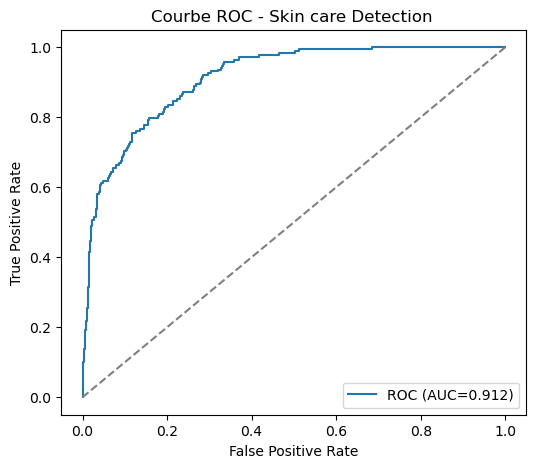


Optimal Thresh (Indice de Youden) = 0.512

 Confusion Matrix (Thresh 0.512) :
 [[686 128]
 [ 38 150]]

 Classification Report (Thresh 0.512) :
               precision    recall  f1-score   support

           0      0.948     0.843     0.892       814
           1      0.540     0.798     0.644       188

    accuracy                          0.834      1002
   macro avg      0.744     0.820     0.768      1002
weighted avg      0.871     0.834     0.845      1002



In [6]:

# --- 1. Chargement du modèle entraîné ---
model = get_model("resnet50", num_classes=2, pretrained=False).to(dev)

if not os.path.exists(SAVE_PATH):
    print(f"\n!!! Le fichier modèle '{SAVE_PATH}' n'existe pas. Assurez-vous d'avoir exécuté et réussi la cellule d'entraînement.")
else:
    print("\n--- Démarrage de l'évaluation sur le jeu de test ---")
    model.load_state_dict(torch.load(SAVE_PATH, map_location=dev))
    model.eval()

    # --- 2. Chargement des données de test ---
    # Réutiliser les paramètres du cfg, même si evaluate_model.py utilisait 128
    _, _, test_ds, _, _, test_dl = get_dataloaders(
        data_dir="data",
        img_size=cfg["img_size"],
        batch_size=cfg["batch_size"],
        num_workers=0
    )

    y_true, y_pred, y_scores = [], [], []

    # --- 3. Prédictions ---
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(dev), y.to(dev)
            out = model(x)
            # Proba de la classe 1 (malignant/cancer)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = torch.argmax(out, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true, y_pred, y_scores = np.array(y_true), np.array(y_pred), np.array(y_scores)

    # --- 4. Affichage des métriques (Seuil 0.5) ---
    cm = confusion_matrix(y_true, y_pred)
    print("\n Confusion Matrix (Seuil 0.5 par défaut) :\n", cm)

    print("\n Classification Report (Seuil 0.5 par défaut) :\n", classification_report(y_true, y_pred, digits=3))

    # --- 5. Courbe ROC et AUC ---
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    print(f"AUC : {roc_auc:.3f}")
    

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Courbe ROC - Skin care Detection ")
    plt.legend()
    plt.show()

    # --- 6. Détermination du Seuil Optimal (Indice de Youden) ---
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_thresh = thresholds[best_idx]
    print(f"\nOptimal Thresh (Indice de Youden) = {best_thresh:.3f}")

    # --- 7. Évaluation avec le seuil optimal ---
    chosen_thresh = best_thresh
    y_pred_new = (y_scores >= chosen_thresh).astype(int)

    cm_new = confusion_matrix(y_true, y_pred_new)
    print(f"\n Confusion Matrix (Thresh {chosen_thresh:.3f}) :\n", cm_new)
    print(f"\n Classification Report (Thresh {chosen_thresh:.3f}) :\n",
          classification_report(y_true, y_pred_new, digits=3))

### Application Démo

In [7]:

MODEL_INFOS = {
    "resnet50": {
        "path": "model_resnet50.pth",
        "label": "ResNet-50 (Transfer Learning)"
    },
    "efficientnet_b0": {
        "path": "model_efficientnet_b0.pth",
        "label": "EfficientNet-B0"
    },
    "cnn_custom": {
        "path": "model_cnn_custom.pth",
        "label": "Custom CNN"
    },
}

# Seuils optimaux trouvés lors de l'évaluation (basés sur les fichiers originaux)
THRESHOLDS = {
    "cnn_custom": 0.531,
    "efficientnet_b0": 0.656,
    "resnet50": 0.487, # Utilisé pour la démo, différent du best_thresh trouvé ci-dessus
}

MODELS = {}
IMG_SIZE = 128

print("\n--- Chargement des modèles pour l'interface Gradio ---")
for name, info in MODEL_INFOS.items():
    try:
        print(f"Loading model '{name}' from {info['path']} ...")
        model = get_model(name, num_classes=2, pretrained=False).to(dev)
        state = torch.load(info["path"], map_location=dev)
        model.load_state_dict(state)
        model.eval()
        MODELS[name] = model
        print("  -> Loaded successfully")
    except Exception as e:
        print(f"  !! Failed to load {name} (Fichier manquant ou erreur): {e}")


# --- Transformations pour la prédiction (validation) ---
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

CLASSES = ["benign (non-cancer)", "malignant (cancer)"]

def predict(image: Image.Image, model_name: str):
    """Fonction de prédiction appelée par l'interface Gradio."""

    if image is None:
        return "Veuillez charger une image."

    if model_name not in MODELS:
        return f"Le modèle '{model_name}' n'est pas disponible (voir les erreurs de chargement)."

    model = MODELS[model_name]
    threshold = THRESHOLDS.get(model_name, 0.5)

    x = val_tf(image).unsqueeze(0).to(dev)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    p_benign = float(probs[0])
    p_malignant = float(probs[1])

    has_cancer = p_malignant >= threshold

    if has_cancer:
        diagnosis = " Suspicion de CANCER DE LA PEAU (maligne)"
    else:
        diagnosis = " Lésion probablement bénigne (non-cancer)"

    model_label = MODEL_INFOS[model_name]["label"]

    text = (
        f"Modèle utilisé: {model_label}\n"
        f"{diagnosis}\n\n"
        f"Probabilité Bénigne :  {p_benign:.3f}\n"
        f"Probabilité Maligne : {p_malignant:.3f}\n"
        f"Seuil de classification pour 'cancer' : {threshold:.3f}\n\n"
        f"⚠️ Cet outil est une assistance et ne remplace PAS un dermatologue."
    )

    return text


# --- Création et Lancement de l'interface Gradio ---
model_dropdown = gr.Dropdown(
    choices=[
        ("ResNet-50 (Transfer Learning)", "resnet50"),
        ("EfficientNet-B0", "efficientnet_b0"),
        ("Custom CNN", "cnn_custom"),
    ],
    value="resnet50",
    label="Choisir le modèle",
)

iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil", label="Image de lésion cutanée"),
        model_dropdown,
    ],
    outputs=gr.Textbox(label="Résultat du Modèle"),
    title="Détection du Cancer de la Peau — Assistant Diagnostique",
    description=(
        "Chargez une image de lésion cutanée et choisissez un modèle de classification."
    ),
)


if __name__ == "__main__":
    iface.launch(inbrowser=True, share=False)


--- Chargement des modèles pour l'interface Gradio ---
Loading model 'resnet50' from model_resnet50.pth ...
  -> Loaded successfully
Loading model 'efficientnet_b0' from model_efficientnet_b0.pth ...
  !! Failed to load efficientnet_b0 (Fichier manquant ou erreur): [Errno 2] No such file or directory: 'model_efficientnet_b0.pth'
Loading model 'cnn_custom' from model_cnn_custom.pth ...
  !! Failed to load cnn_custom (Fichier manquant ou erreur): [Errno 2] No such file or directory: 'model_cnn_custom.pth'
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
